In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

import re
import string
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\13462\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install spacy

**Removing blank lines from each text file**

In [3]:
folder = 'Articles'

file_names = [file_name for file_name in os.listdir(folder) if file_name.endswith('.txt')]

for file_name in file_names:
    with open(os.path.join(folder, file_name), 'r', encoding='latin-1') as file:
        lines = file.readlines()

    lines = [line.strip() for line in lines if line.strip()]

    with open(os.path.join(folder, file_name), 'w', encoding='latin-1') as file:
        _=file.write('\n'.join(lines))
        _=file.truncate()

**Splitting each text file into separate articles and separating meta data from actual data:**

* Create a separate folder called "Articles_split" where all the individual articles are stored
* Remove any articles that are blank



In [4]:
folder_out = 'Articles_split'

if not os.path.exists(folder_out):
    os.makedirs(folder_out)

end_pattern = r'Document\s+\w+'

file_names = [file_name for file_name in os.listdir(folder) if file_name.endswith('.txt')]

for file_name in file_names:
    with open(os.path.join(folder, file_name), 'r', encoding='latin-1') as file:
        file_contents = file.read()

    articles = re.split(end_pattern, file_contents) #splitting the text files into articles based on end pattern

    # Write those splitted articles into separate text files and store in output folder defined above
    for i, article in enumerate(articles):
        article_filename = f'{os.path.splitext(file_name)[0]}_article_{i + 1}.txt'

        with open(os.path.join(folder_out, article_filename), 'w', encoding='latin-1') as output_file:
            _=output_file.write(article)

    # Removing blank articles:
    if os.path.getsize(os.path.join(folder_out, article_filename)) == 0 or open(os.path.join(folder_out, article_filename), encoding='latin-1').read().isspace():
        _=os.remove(os.path.join(folder_out, article_filename))

**Preprocessing**

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [6]:
processed_text = []

file_names = [file_name for file_name in os.listdir(folder_out) if file_name.endswith('.txt')]

for file_name in file_names:

    with open(os.path.join(folder_out, file_name), 'r', encoding='latin-1') as file:
        text = file.read().strip()

        #Remove punctuation
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        #Remove numbers
        text = re.sub(r'\d+', '', text)

        #Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

        #Tokenization
        words = word_tokenize(text)

        #Lowercase
        words = [word.lower() for word in words]

        #Remove stopwords
        words = [word for word in words if word not in stop_words]

        #Lemmatization
        lemma = WordNetLemmatizer()
        words = [lemma.lemmatize(word) for word in words]

        #Stemming
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

        #Normalization and Cleaning
        text = ' '.join(words)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'can\'t', 'cannot', text)

        processed_text.append(text)

**Finding most frequent 30 terms**

In [7]:
processed_words = []
corpus_words = []
for i in processed_text:
    processed_words.append(i.split())
    corpus_words.extend(i.split())

In [8]:
freq_dist = nltk.FreqDist(corpus_words)
freq_10 = freq_dist.most_common(30)

df_freq_10 = pd.DataFrame(freq_10, columns=['Common Words', 'Frequency'])
df_freq_10

,Common Words,Frequency
0,said,11690
1,state,10494
2,mr,10022
3,trump,7724
4,islam,6718
5,new,6228
6,time,5997
7,u,4969
8,presid,4627
9,attack,4353


**Word Cloud for most common words in corpus**

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

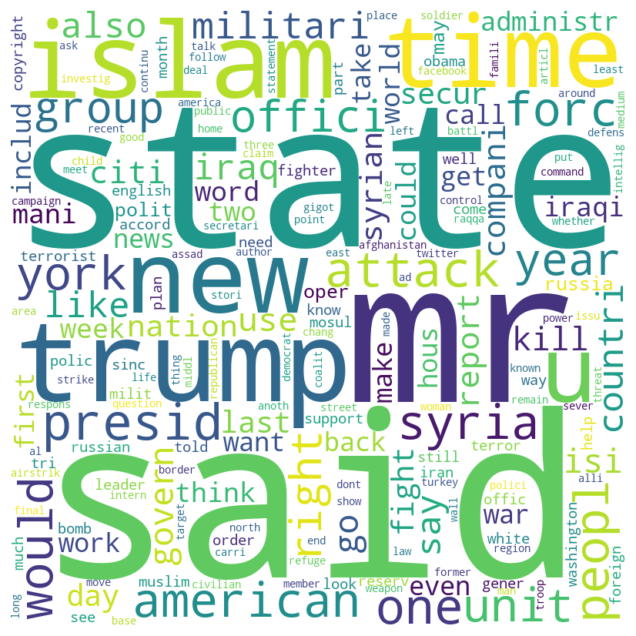

In [9]:
# Most common words in corpus using Word Cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(freq_dist))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Word Cloud for 30 most frequent words**

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

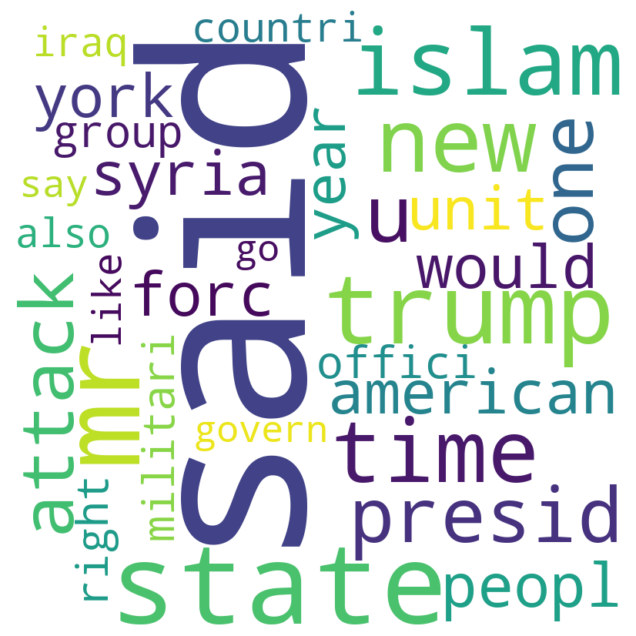

In [10]:
# 30 most frequent words in corpus using Word Cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(freq_10))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Topic Modeling**

In [11]:
from pprint import pprint
import gensim # Gensim for Topic Modeling
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(processed_words)

# Create Corpus
texts = processed_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
topics_no = 15

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics_no, #play with this number
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100, #keep this same
                                           passes=10, #keep this same
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"isotop" + 0.000*"kennel" + 0.000*"hardleft" + 0.000*"huang" + '
  '0.000*"hun" + 0.000*"improvisatori" + 0.000*"inbreed" + 0.000*"ge" + '
  '0.000*"joss" + 0.000*"lsisi"'),
 (1,
  '0.015*"think" + 0.015*"trump" + 0.014*"go" + 0.013*"gigot" + 0.011*"presid" '
  '+ 0.009*"right" + 0.009*"say" + 0.008*"get" + 0.008*"u" + 0.008*"peopl"'),
 (2,
  '0.011*"brown" + 0.010*"martha" + 0.009*"book" + 0.006*"vineyard" + '
  '0.006*"seller" + 0.006*"mastermind" + 0.006*"advers" + 0.005*"week" + '
  '0.005*"review" + 0.004*"fiction"'),
 (3,
  '0.016*"compani" + 0.016*"u" + 0.013*"new" + 0.012*"accord" + 0.012*"inc" + '
  '0.011*"investig" + 0.010*"jone" + 0.010*"feder" + 0.009*"journal" + '
  '0.009*"fbi"'),
 (4,
  '0.047*"mr" + 0.025*"trump" + 0.019*"said" + 0.015*"presid" + 0.012*"state" '
  '+ 0.010*"administr" + 0.010*"u" + 0.010*"offici" + 0.008*"russia" + '
  '0.007*"secur"'),
 (5,
  '0.010*"time" + 0.009*"new" + 0.007*"one" + 0.007*"like" + 0.006*"compani" + '
  '0.005*"world" 

In [15]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -9.274517267420677

Coherence Score:  0.4093069653305534


In [16]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.187025  0.165520       1        1  17.757486
6      0.183776  0.082180       2        1  17.319104
4      0.257684  0.002588       3        1  17.210334
13     0.250168 -0.140609       4        1  15.126239
1      0.220035  0.220189       5        1  13.266658
12     0.188454 -0.191789       6        1   6.861357
7      0.181068 -0.054751       7        1   5.141880
3      0.163520 -0.001000       8        1   4.643793
9     -0.117939 -0.032847       9        1   1.558348
8     -0.116342 -0.193542      10        1   0.890387
2     -0.272056  0.039610      11        1   0.146959
11    -0.287130  0.026937      12        1   0.075145
14    -0.279421  0.025838      13        1   0.000781
10    -0.279421  0.025838      14        1   0.000771
0     -0.279421  0.025838      15        1   0.000759, topic_info=       Term          Freq         Total Category  logprob  loglift
224   state  10602.000000  10602.000000  Default  30.0000  30.0000
420      mr  10999.000000  10999.000000  Default  29.0000  29.0000
22   attack   4678.000000   4678.000000  Default  28.0000  28.0000
123   islam   7621.000000   7621.000000  Default  27.0000  27.0000
238   trump   6813.000000   6813.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
25    becom      0.000236    835.236860  Topic15 -10.4632  -3.2912
26    began      0.000236    738.995076  Topic15 -10.4632  -3.1688
27    begin      0.000236    490.998261  Topic15 -10.4632  -2.7599
28    begun      0.000236    124.674740  Topic15 -10.4632  -1.3892
29   believ      0.000236    760.420966  Topic15 -10.4632  -3.1974

[992 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5963      4  0.023867        abadi
5963      7  0.975572        abadi
7797      6  0.991183  abouyaaqoub
649       2  0.211404          abu
649       4  0.518677          abu
...     ...       ...          ...
545       6  0.963515      youssef
1553      1  0.994581       youtub
3518      5  0.995597         youv
2373      7  0.996740          ypg
1906      1  0.996641   zuckerberg

[2027 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 5, 14, 2, 13, 8, 4, 10, 9, 3, 12, 15, 11, 1])

In [17]:
# Create the output directory if it doesn't exist
if not os.path.exists('output_summaries'):
    os.makedirs('output_summaries')

In [18]:
# Storing model summaries into output file
with open(f'output_summaries/lda_summary_{topics_no}_.txt', 'w') as f:
    _=f.write('Number of Topics: '+str(topics_no)+'\n')
    _=f.write('\n'+str(lda_model.print_topics(num_topics=topics_no, num_words=10))+'\n')
    _=f.write('\nPerplexity: '+str(lda_model.log_perplexity(corpus))+'\n')
    _=f.write('\nCoherence Score: '+str(coherence_lda))